# Машинное обучение, ПМИ ФКН ВШЭ

## Рекомендательные системы

Для начала скачаем небольшое подмножество [данных](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?select=movies_metadata.csv) об оценках фильмов пользователями.

In [ ]:
%%bash
kaggle datasets download -d rounakbanik/the-movies-dataset -f links_small.csv
kaggle datasets download -d rounakbanik/the-movies-dataset -f ratings_small.csv
kaggle datasets download -d rounakbanik/the-movies-dataset -f movies_metadata.csv
unzip ratings_small.csv.zip
rm ratings_small.csv.zip
unzip movies_metadata.csv.zip
rm movies_metadata.csv.zip

In [1]:
import pandas as pd
import numpy as np
import scipy.sparse as scs
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings

warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size': 14})
sns.set_style('whitegrid')

Загрузим данные и пообъединяем таблички, чтобы добавить к рейтингам метаданные фильмов (в нашем случае только название для удобства интерпретации).

In [2]:
links = pd.read_csv('links_small.csv').dropna()
links.tmdbId = links.tmdbId.astype(int).astype(object)
links = links.rename(columns={'tmdbId': 'id'})

# merge metadata with links to get (movieId, title) pairs
metadata = pd.read_csv('movies_metadata.csv')
bad_index = metadata[metadata.id.apply(lambda x: not x.isdigit())].index
metadata = metadata.drop(bad_index)
metadata.id = metadata.id.astype(int)
metadata = metadata.merge(links, on='id')

# merge movies titles with ratings
ratings = pd.read_csv('ratings_small.csv')
ratings = ratings.merge(metadata[['movieId', 'title']], on='movieId')

# normalize userId and movieId
ratings.userId = ratings.userId - 1
ids = ratings.movieId.unique()
ids.sort()
ordered_ids = pd.factorize(ids)
mapper = pd.Series(ordered_ids[0], ordered_ids[1])
ratings.movieId = ratings.movieId.map(mapper)
ratings = ratings.sort_values(['userId', 'timestamp'])

ratings

,userId,movieId,rating,timestamp,title
706,0,1811,2.0,1260759108,Antz
759,0,1958,2.5,1260759113,The Fly
849,0,2920,3.0,1260759117,Blazing Saddles
351,0,1079,3.5,1260759125,Dracula
403,0,1083,2.0,1260759131,Cape Fear
...,...,...,...,...,...
89722,670,2622,4.0,1070940360,Of Mice and Men
59995,670,4588,4.0,1070940363,The Matrix Reloaded
60028,670,4601,2.5,1070979663,Whale Rider
80461,670,4687,3.5,1074784724,Seabiscuit


Посмотрим, сколько всего есть уникальных фильмов и пользователей.

In [3]:
num_users, num_movies = ratings.userId.max() + 1, ratings.movieId.max() + 1
num_users, num_movies

(671, 9025)

Разделим выборку на обучение и тест следующим образом: для каждого пользователя в тестовую выборку попадут 10 его последних оценок.

In [4]:
train_ratings, test_ratings = [], []
num_test_samples = 10

for userId, user_data in ratings.groupby('userId'):
    train_ratings += [user_data[:-num_test_samples]]
    test_ratings += [user_data[-num_test_samples:]]

train_ratings = pd.concat(train_ratings)
test_ratings = pd.concat(test_ratings)
train_ratings.shape, test_ratings.shape

((93140, 5), (6710, 5))

Посмотрим на распределение рейтингов на обучении.

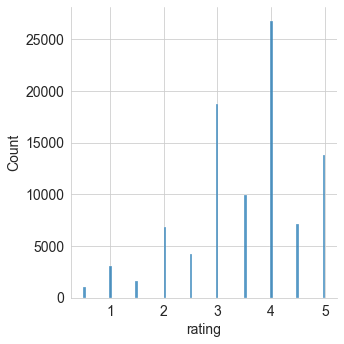

In [5]:
_ = sns.displot(train_ratings.rating)

И на распределение числа оценок для разных фильмов. Видим типичную ситуацию с длинным хвостом распределения.

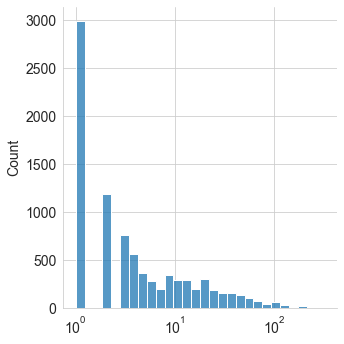

In [6]:
_ = sns.displot(train_ratings.groupby('movieId').size(), log_scale=True)

На таких маленьких данных мы можем позволить себе обучить полный ALS с честным обращением матриц.

In [20]:
def ALS(user_ids, item_ids, ratings, num_users, num_items, num_dims=64, num_iters=10, eps=1e-7):
    R = scs.coo_array((ratings, (user_ids, item_ids)), shape=(num_users, num_items)).tocsr()
    P = np.random.randn(num_users, num_dims)
    Q = np.random.randn(num_items, num_dims)
    
    for t in tqdm(range(num_iters)):
        RQ = R @ Q
        for u in range(num_users):
            relevant_items = item_ids[user_ids == u]
            Q_rel = Q[relevant_items]
            QQ = Q_rel.reshape(-1, num_dims, 1) * Q_rel.reshape(-1, 1, num_dims)
            P[u] = np.linalg.inv(QQ.sum(axis=0) + eps * np.eye(num_dims)) @ RQ[u]

        RP = R.T @ P
        for i in range(num_items):
            relevant_users = user_ids[item_ids == i]
            P_rel = P[relevant_users]
            PP = P_rel.reshape(-1, num_dims, 1) * P_rel.reshape(-1, 1, num_dims)
            Q[i] = np.linalg.inv(PP.sum(axis=0) + eps * np.eye(num_dims)) @ RP[i]
    
    return P, Q

In [21]:
P, Q = ALS(train_ratings.userId, train_ratings.movieId, train_ratings.rating, num_users, num_movies, num_iters=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Сгенерируем предсказания, посчитав скалярные произведения между векторами пользователей и фильмов.

In [22]:
train_preds = (P[train_ratings.userId] * Q[train_ratings.movieId]).sum(axis=1)
test_preds = (P[test_ratings.userId] * Q[test_ratings.movieId]).sum(axis=1)
test_preds = np.clip(test_preds, 0.5, 5.0)

In [23]:
from sklearn.metrics import r2_score

print(f'Train R^2: {r2_score(train_ratings.rating, train_preds):.3f}')
print(f'Test R^2: {r2_score(test_ratings.rating, test_preds):.3f}')

Train R^2: 0.992
Test R^2: -2.264


Результаты получились весьма удручающими. Но не будем забывать, что нас интересует рекомендация фильмов, а не предсказание точно рейтинга. Поэтому упорядочим фильмы по предсказанной релевантности (значение скалярного произведения) и посчитаем метрику для ранжирования &mdash; MAP@k. Для сравнения рассмотрим еще два алгоритма &mdash; случайный (ранжирует фильмы в произвольном порядке) и алгоритм, возвращающий топ рейтинга фильмов.

In [24]:
test_relevant = []
for user_id, user_data in test_ratings[test_ratings.rating >= 4.0].groupby('userId'):
    test_relevant += [user_data.movieId.tolist()]

In [25]:
def remove_train_items(preds, k):
    new_preds = np.zeros((preds.shape[0], k), dtype=np.int)
    for user_id, user_data in train_ratings.groupby('userId'):
        user_preds = preds[user_id]
        new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data.movieId)][:k]
    
    return new_preds


def ALS_prediction(P, Q, k=10):
    preds = np.argsort(P @ Q.T, axis=1)
    preds = remove_train_items(preds, k)
    return preds


def random_prediction(k=10):
    preds = np.tile(np.arange(num_movies), (num_users, 1))
    for i in range(num_users):
        rand_perm = np.random.permutation(num_movies)
        preds[i] = preds[i][rand_perm]

    preds = remove_train_items(preds, k)
    return preds


def top_prediction(freq_thr=10, k=10):
    mean_rating = train_ratings.groupby('movieId').rating.mean()
    mean_rating = mean_rating[train_ratings.groupby('movieId').size() >= freq_thr]
    preds = np.array(mean_rating.sort_values(ascending=False).index)
    preds = np.tile(preds, (num_users, 1))
    preds = remove_train_items(preds, k)
    return preds


def MAPk(y_true, y_pred, k=10):
    map_k, count = 0, 0
    for relevant_items, predicted_items in zip(y_true, y_pred):
        if not relevant_items:
            continue
        
        correct = np.isin(predicted_items[:k], relevant_items)
        map_k += (correct / np.arange(1, k + 1)).sum() / \
            (1 / np.arange(1, len(relevant_items) + 1)).sum()
        count += 1
    
    map_k = map_k / count
    return map_k

Посчитаем значение MAP@k для разных значений k.

In [26]:
ks = np.arange(1, 51)
als_preds = ALS_prediction(P, Q, k=ks[-1])
random_preds = random_prediction(k=ks[-1])
top_preds = top_prediction(freq_thr=10, k=ks[-1])

random_mapk = [MAPk(test_relevant, random_preds, k=k) for k in ks]
top_mapk = [MAPk(test_relevant, top_preds, k=k) for k in ks]
als_mapk = [MAPk(test_relevant, als_preds, k=k) for k in ks]

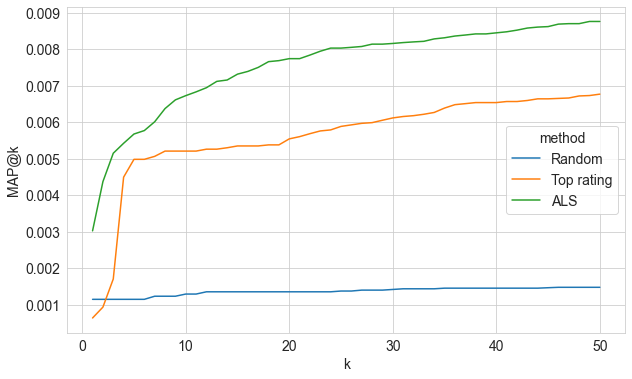

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(ks, random_mapk, label='Random')
plt.plot(ks, top_mapk, label='Top rating')
plt.plot(ks, als_mapk, label='ALS')

plt.legend(title='method')
plt.xlabel('k')
plt.ylabel('MAP@k')
plt.show()

Что ж, даже небольшого числа данных хватило, чтобы обойти бейзлайн с предсказанием топа рейтинга. Померяем также две метрики, которые характеризуют разнообразность предсказаний: *coverage* &mdash; доля фильмов из базы, которые в принципе рекомендуются и *personalization* &mdash; среднее косинусное расстояние между бинарными векторами рекомендаций для разных пользователей.

In [28]:
from sklearn.metrics.pairwise import cosine_similarity


def coverage(preds):
    return np.unique(preds.flatten()).size / num_movies


def personalization(preds):
    N = preds.shape[0]
    ohe_matrix = np.zeros((N, num_movies))
    ohe_matrix[np.arange(N).repeat(preds.shape[1]), preds.reshape(-1)] = 1.
    sim_matrix = cosine_similarity(ohe_matrix)
    return 1 - (sim_matrix.sum() - N) / (N * (N - 1))

In [29]:
print(f'Random coverage: {coverage(random_preds):.4f}')
print(f'Top rating coverage: {coverage(top_preds):.4f}')
print(f'ALS coverage: {coverage(als_preds):.4f}')

Random coverage: 0.9761
Top rating coverage: 0.0171
ALS coverage: 0.1603


In [30]:
print(f'Random personalization: {personalization(random_preds):.4f}')
print(f'Top rating personalization: {personalization(top_preds):.4f}')
print(f'ALS personalization: {personalization(als_preds):.4f}')

Random personalization: 0.9944
Top rating personalization: 0.1048
ALS personalization: 0.8561


Как мы видим, лучшим разнообразием обладает случайный алгоритм (как неожиданно!). Впрочем, ALS показывает относительно неплохой уровень personalization, что означает, что мы действительно построили *рекомендательную* систему. Кроме того, можем попробовать использовать обученные векторы фильмов, чтобы выдавать фильмы, похожие на данные запрос, например:

In [31]:
example_movieId = ratings[ratings.title=='Iron Man'].iloc[0].movieId
scores = Q @ Q[example_movieId]
similar_movies = np.argsort(-scores)[:20]

for movieId in similar_movies:
    normalized_score = scores[movieId] / np.linalg.norm(Q[example_movieId]) / np.linalg.norm(Q[movieId])
    print(f'{ratings[ratings.movieId == movieId].iloc[0].title}: {normalized_score:.3f}')

The Royal Tenenbaums: 0.250
Iron Man: 1.000
Platoon: 0.177
V for Vendetta: 0.353
The Game: 0.340
The Patriot: 0.118
Some Like It Hot: 0.278
Addams Family Values: 0.235
Little Miss Sunshine: 0.146
Enemy of the State: 0.215
Run Lola Run: 0.154
The Wedding Singer: 0.153
Shaun of the Dead: 0.167
Juno: 0.241
Election: 0.178
The Exorcist: 0.124
Vertigo: 0.209
The American President: 0.269
American Pie: 0.387
Starship Troopers: 0.166
